Found 11801 images belonging to 3 classes.
Found 5056 images belonging to 3 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 93 steps, validate for 40 steps
Epoch 1/30
92/93 [============================>.] - ETA: 9s - loss: 4.5855 - accuracy: 0.7539 
Epoch 00001: val_loss improved from inf to 0.34464, saving model to ./InceptionResNetV2/weights-InceptionResNetV2.hdf5
93/93 [==============================] - 1195s 13s/step - loss: 4.5403 - accuracy: 0.7551 - val_loss: 0.3446 - val_accuracy: 0.8661
Epoch 2/30
92/93 [============================>.] - ETA: 8s - loss: 0.3524 - accuracy: 0.8454 
Epoch 00002: val_loss improved from 0.34464 to 0.29083, saving model to ./InceptionResNetV2/weights-InceptionResNetV2.hdf5
93/93 [==============================] - 1166s 13s/step - loss: 0.3514 - accuracy: 0.8456 - val_loss: 0.2908 - val_accuracy: 0.9007
Epoch 3/30
92/93 [============================>.] - ETA: 8s - loss: 0.2956 - accuracy: 0.8724 
Epoch 00003: val_loss improved f

92/93 [============================>.] - ETA: 8s - loss: 0.1129 - accuracy: 0.9652 
Epoch 00023: val_loss did not improve from 0.08648

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.
93/93 [==============================] - 1151s 12s/step - loss: 0.1132 - accuracy: 0.9652 - val_loss: 0.1013 - val_accuracy: 0.9725
Epoch 24/30
92/93 [============================>.] - ETA: 8s - loss: 0.1041 - accuracy: 0.9676 
Epoch 00024: val_loss did not improve from 0.08648

Epoch 00024: ReduceLROnPlateau reducing learning rate to 7.629394893626795e-09.
93/93 [==============================] - 1151s 12s/step - loss: 0.1035 - accuracy: 0.9677 - val_loss: 0.0904 - val_accuracy: 0.9729
Epoch 25/30
92/93 [============================>.] - ETA: 8s - loss: 0.1083 - accuracy: 0.9688 
Epoch 00025: val_loss improved from 0.08648 to 0.08639, saving model to ./InceptionResNetV2/weights-InceptionResNetV2.hdf5

Epoch 00025: ReduceLROnPlateau reducing learning rate to 3.8146974468133

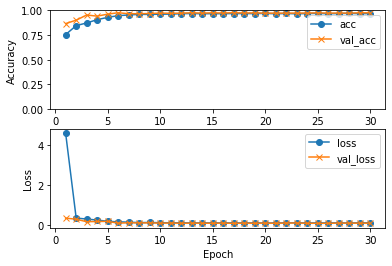

tf.Tensor(
[[ 730   21   11]
 [   5 2392    3]
 [  65   15 1814]], shape=(3, 3), dtype=int32)


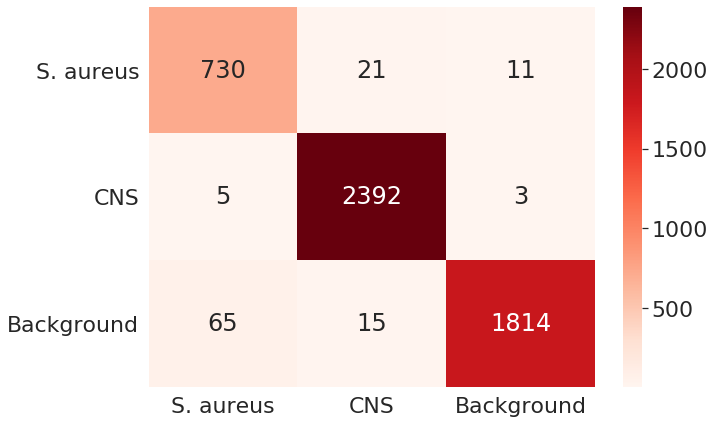

[[0.9999976, 1.0, 0.9941088], [0.8412655, 1.0, 0.98543453], [0.99185306, 1.0, 1.0]]
[[575, 546, 751], [1979, 762, 1780], [3635, 3474, 3162]]


In [12]:
import os
import pickle
import shutil
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, InceptionV3, InceptionResNetV2, EfficientNetB0
from tensorflow.python.keras.engine import training
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# TPU initialization
#try:
#  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#except ValueError:
#  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Base model for fine tuning
def get_base_model(modelname, input_shape):
    if modelname == "InceptionResNetV2":
        # InceptionResNetV2
        base_model = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=input_shape)
        for layer in base_model.layers[:775]:
            layer.trainable = False

    elif modelname == "EfficientNetB0":
        base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)
        for layer in base_model.layers[-20:]:
                if not isinstance(layer, layers.BatchNormalization):
                    layer.trainable = True

    elif modelname == "InceptionV3":
        base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)
        for layer in base_model.layers[:249]:
            layer.trainable = False
            if layer.name.startswith('batch_normalization'):
                layer.trainable = True

        for layer in base_model.layers[249:]:
            layer.trainable = True

    elif modelname == "VGG16":
        base_model = VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
        for layer in base_model.layers[:15]:
            layer.trainable = False

    elif modelname == "SmallCNN":
        layer_input = Input(shape=input_shape)

        layer_output = Conv2D(32, (3,3), activation="relu")(layer_input)
        layer_output = MaxPooling2D(pool_size=(2,2))(layer_output)

        layer_output = Conv2D(32, (3,3), activation="relu")(layer_output)
        layer_output = MaxPooling2D(pool_size=(2,2))(layer_output)

        layer_output = Conv2D(64, (3,3), activation="relu")(layer_output)
        layer_output = MaxPooling2D(pool_size=(2,2))(layer_output)

        base_model = training.Model(layer_input, layer_output, name='smallcnn')
    else:
        print("Unknown model name")
        exit(1)
    
    return base_model

# Project name and directories
# Choose one from following  SmallCNN, VGG16, InceptionV3, InceptionResNetV2, EfficientNetB0
ver = "InceptionResNetV2"

#base_dir = "./drive/My Drive/" # for Google colab
base_dir = "./"                 # for local use
data_dir = base_dir + "images"
ver_dir = base_dir + ver
processed_dir = ver_dir + "/processed"

os.makedirs(processed_dir, exist_ok=True)

# Parameters
batch_size = 128
epochs = 30
#classes = [filename for filename in os.listdir(data_dir) if not filename.startswith('.')]
classes = ["Staphylococcus aureus", "Coagulase-negative Staphylococcus", "Background"]
num_classes = len(classes)
img_width, img_height = 512, 512
feature_dim = (img_width, img_height, 3)

# Image data generator
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
#    rotation_range=90,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.3
)

#dog or cat-> binary, if more, set "categorical"
class_mode = "binary" if num_classes == 2 else "categorical"
train_generator = datagen.flow_from_directory(
    data_dir,
    subset="training",
    target_size=(img_width, img_height),
    color_mode="rgb",
    classes=classes,
    class_mode=class_mode, 
    batch_size=batch_size,
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    subset="validation",
    target_size=(img_width, img_height),
    color_mode="rgb",
    classes=classes,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=False
)

# Save class_indices
class_indices_path = os.path.join(ver_dir, 'class_indices.pickle')
with open(class_indices_path,'wb') as f:
    pickle.dump(train_generator.class_indices, f)

# This is the TPU initialization code that has to be at the beginning.
#tf.keras.backend.clear_session()
#resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
#tf.config.experimental_connect_to_cluster(resolver)

#tf.tpu.experimental.initialize_tpu_system(resolver)
#print("All devices: ", tf.config.list_logical_devices('TPU'))
#strategy = tf.distribute.experimental.TPUStrategy(resolver)

#with strategy.scope():
# Model definition
# If class_mode="binary", set 1 to Dense layer
# If class_mode="categorical", set num_classes to Dense layer
num_dense = 1 if num_classes == 2 else num_classes
activation = "sigmoid" if num_classes == 2 else "softmax"
base_model = get_base_model(ver, feature_dim)
layer_output = base_model.output
layer_output = Flatten()(layer_output)
layer_output = Dense(256, 
#                       kernel_regularizer=regularizers.l2(100),
                       activation="relu"
                       )(layer_output)
layer_output = Dropout(0.5)(layer_output)
layer_output = Dense(num_dense, activation=activation)(layer_output)

model = Model(base_model.input, layer_output)
#model.summary()
loss = "binary_crossentropy" if num_classes == 2 else "categorical_crossentropy"
model.compile(
  loss=loss,
#    optimizer=SGD(lr=1e-4, momentum=0.9),
  optimizer="Adam",
  metrics=["accuracy"]
)
# end of strategy.scope()

# Training
cp_cb = ModelCheckpoint(
    filepath=ver_dir + "/" + "weights-" + ver + ".hdf5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
    mode="min"
)

es_cb = EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    verbose=1, 
    mode='auto'
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    verbose=1
)

num_train_samples = train_generator.n
num_validation_samples = validation_generator.n
steps_per_epoch_train = (num_train_samples-1) // batch_size + 1
steps_per_epoch_validation  = (num_validation_samples-1) // batch_size + 1
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    callbacks=[cp_cb, reduce_lr_cb]
)

hist_df = pd.DataFrame(history.history)
hist_df.to_csv(ver_dir + '/history.csv')

# Trend line
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.set_ylim(0, 1)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
rng = range(1, len(history.history["accuracy"]) + 1)
ax.plot(rng, history.history["accuracy"], label="acc", ls="-", marker="o")
ax.plot(rng, history.history["val_accuracy"], label="val_acc", ls="-", marker="x")
ax.legend()

ax = fig.add_subplot(2,1,2)
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.plot(rng, history.history["loss"], label="loss", ls="-", marker="o")
ax.plot(rng, history.history["val_loss"], label="val_loss", ls="-", marker="x")
ax.legend()
plt.show()

# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

sns.set(font_scale=2)

pred = model.predict(validation_generator)
y_pred = np.argmax(pred, axis=1)

cmx_data = tf.math.confusion_matrix(validation_generator.classes, y_pred)

print(cmx_data)

plt.figure(figsize = (10,7))
labels = ["S. aureus", "CNS", "Background"]
sns.heatmap(cmx_data, annot=True, cmap="Reds", xticklabels=labels, yticklabels=labels, fmt="d")
plt.yticks(rotation=0) 
plt.show()


# most likely images
likely_dir = os.path.join(ver_dir, "most_likely")
os.makedirs(likely_dir, exist_ok=True)

max_val = [[0] * 3 for i in range(3)]
max_idx = [[0] * 3 for i in range(3)]

for i in range(len(pred)):
  pred_idx = np.argmax(pred[i])
  true_idx = validation_generator.classes[i]
  if pred[i][pred_idx] > max_val[true_idx][pred_idx]:
    max_val[true_idx][pred_idx] = pred[i][pred_idx]
    max_idx[true_idx][pred_idx] = i

print(max_val)
print(max_idx)

for i in range(3):
  for j in range(3):
    idx = max_idx[i][j]
    shutil.copy(os.path.join(data_dir, validation_generator.filenames[idx]), os.path.join(likely_dir, "{}to{}.png".format(i, j)))

# Save NG images
ng_dir = os.path.join(ver_dir, "NGs")
os.makedirs(ng_dir, exist_ok=True)
for i in range(num_classes):
  for j in range(num_classes):
    if i != j:
      os.makedirs(os.path.join(ng_dir, "{}to{}".format(i, j)), exist_ok=True)

for i in range(len(pred)):
  pred_arg = np.argmax(pred[i])
  if pred_arg != validation_generator.classes[i]:
    shutil.copy(os.path.join(data_dir, validation_generator.filenames[i]), os.path.join(ng_dir, "{}to{}".format(validation_generator.classes[i], pred_arg)))


Loaded ./InceptionResNetV2/weights-InceptionResNetV2.hdf5
########################### Summary #############################
Staphylococcus aureus                              89.7768%
Background                                          6.5696%
Coagulase-negative Staphylococcus                   3.6536%
Evaluated .//ROC/Staphylococcus aureus/IMG_3795.JPG
########################### Summary #############################
Staphylococcus aureus                              20.6635%
Background                                          1.0524%
Coagulase-negative Staphylococcus                  78.2841%
Evaluated .//ROC/Staphylococcus aureus/IMG_2820.JPG
########################### Summary #############################
Staphylococcus aureus                              71.0878%
Background                                          2.7893%
Coagulase-negative Staphylococcus                  26.1229%
Evaluated .//ROC/Staphylococcus aureus/IMG_3685.JPG
########################### Summary ############

########################### Summary #############################
Staphylococcus aureus                              66.5975%
Background                                          6.8385%
Coagulase-negative Staphylococcus                  26.5641%
Evaluated .//ROC/Staphylococcus aureus/IMG_3715.JPG
########################### Summary #############################
Staphylococcus aureus                              33.3184%
Background                                          1.5981%
Coagulase-negative Staphylococcus                  65.0835%
Evaluated .//ROC/Staphylococcus aureus/IMG_2819.JPG
########################### Summary #############################
Staphylococcus aureus                              91.7917%
Background                                          0.0533%
Coagulase-negative Staphylococcus                   8.1550%
Evaluated .//ROC/Staphylococcus aureus/IMG_3785.JPG
########################### Summary #############################
Staphylococcus aureus                   

########################### Summary #############################
Staphylococcus aureus                              62.9410%
Background                                          1.7729%
Coagulase-negative Staphylococcus                  35.2861%
Evaluated .//ROC/Staphylococcus aureus/IMG_3803.JPG
########################### Summary #############################
Staphylococcus aureus                              71.2390%
Background                                          6.4474%
Coagulase-negative Staphylococcus                  22.3136%
Evaluated .//ROC/Staphylococcus aureus/IMG_2740.JPG
########################### Summary #############################
Staphylococcus aureus                              55.2335%
Background                                          6.9062%
Coagulase-negative Staphylococcus                  37.8603%
Evaluated .//ROC/Staphylococcus aureus/IMG_3713.JPG
########################### Summary #############################
Staphylococcus aureus                   

########################### Summary #############################
Staphylococcus aureus                              68.8002%
Background                                         10.9236%
Coagulase-negative Staphylococcus                  20.2762%
Evaluated .//ROC/Staphylococcus aureus/IMG_3792.JPG
########################### Summary #############################
Staphylococcus aureus                              74.8192%
Background                                          1.6107%
Coagulase-negative Staphylococcus                  23.5702%
Evaluated .//ROC/Staphylococcus aureus/IMG_3801.JPG
########################### Summary #############################
Staphylococcus aureus                              46.4630%
Background                                          1.4954%
Coagulase-negative Staphylococcus                  52.0416%
Evaluated .//ROC/Staphylococcus aureus/IMG_3706.JPG
########################### Summary #############################
Staphylococcus aureus                   

########################### Summary #############################
Staphylococcus aureus                               6.0362%
Background                                          2.0454%
Coagulase-negative Staphylococcus                  91.9184%
Evaluated .//ROC/Coagulase-negative Staphylococcus/IMG_3477.JPG
########################### Summary #############################
Staphylococcus aureus                              47.2185%
Background                                          1.1873%
Coagulase-negative Staphylococcus                  51.5942%
Evaluated .//ROC/Coagulase-negative Staphylococcus/IMG_3396.JPG
########################### Summary #############################
Staphylococcus aureus                              10.1699%
Background                                          1.4938%
Coagulase-negative Staphylococcus                  88.3364%
Evaluated .//ROC/Coagulase-negative Staphylococcus/IMG_2858.JPG
########################### Summary #############################
Stap

########################### Summary #############################
Staphylococcus aureus                              64.3504%
Background                                          2.3561%
Coagulase-negative Staphylococcus                  33.2935%
Evaluated .//ROC/Coagulase-negative Staphylococcus/IMG_3400.JPG
########################### Summary #############################
Staphylococcus aureus                              18.7646%
Background                                          2.2713%
Coagulase-negative Staphylococcus                  78.9641%
Evaluated .//ROC/Coagulase-negative Staphylococcus/IMG_2862.JPG
########################### Summary #############################
Staphylococcus aureus                               2.0880%
Background                                          0.0646%
Coagulase-negative Staphylococcus                  97.8474%
Evaluated .//ROC/Coagulase-negative Staphylococcus/IMG_3482.JPG
########################### Summary #############################
Stap

########################### Summary #############################
Staphylococcus aureus                              81.7118%
Background                                          0.7880%
Coagulase-negative Staphylococcus                  17.5001%
Evaluated .//ROC/Coagulase-negative Staphylococcus/IMG_3381.JPG
########################### Summary #############################
Staphylococcus aureus                              28.4710%
Background                                          1.7050%
Coagulase-negative Staphylococcus                  69.8240%
Evaluated .//ROC/Coagulase-negative Staphylococcus/IMG_2877.JPG
########################### Summary #############################
Staphylococcus aureus                              16.8742%
Background                                          1.4890%
Coagulase-negative Staphylococcus                  81.6368%
Evaluated .//ROC/Coagulase-negative Staphylococcus/IMG_2870.JPG
########################### Summary #############################
Stap

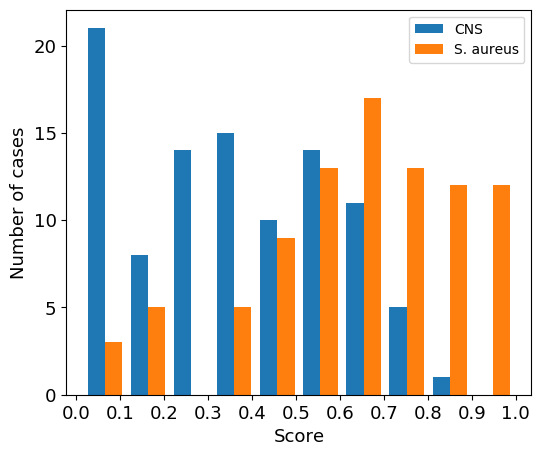

[1.         1.         1.         0.98989899 0.98989899 0.97979798
 0.97979798 0.95959596 0.95959596 0.93939394 0.93939394 0.91919192
 0.91919192 0.90909091 0.90909091 0.8989899  0.8989899  0.88888889
 0.88888889 0.87878788 0.87878788 0.82828283 0.82828283 0.80808081
 0.80808081 0.76767677 0.76767677 0.72727273 0.72727273 0.70707071
 0.70707071 0.6969697  0.6969697  0.68686869 0.68686869 0.67676768
 0.67676768 0.65656566 0.65656566 0.63636364 0.63636364 0.58585859
 0.58585859 0.55555556 0.55555556 0.49494949 0.49494949 0.48484848
 0.48484848 0.29292929 0.29292929 0.24242424 0.24242424 0.23232323
 0.23232323 0.21212121 0.21212121 0.19191919 0.19191919 0.15151515
 0.15151515 0.        ]
[0.         0.01123596 0.25842697 0.25842697 0.28089888 0.28089888
 0.31460674 0.31460674 0.38202247 0.38202247 0.41573034 0.41573034
 0.43820225 0.43820225 0.48314607 0.48314607 0.51685393 0.51685393
 0.52808989 0.52808989 0.53932584 0.53932584 0.60674157 0.60674157
 0.6741573  0.6741573  0.68539326 0.68

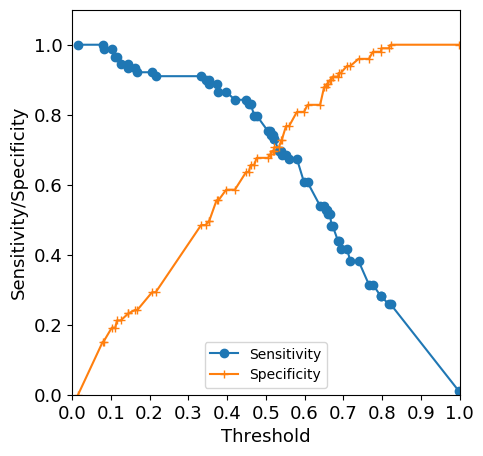

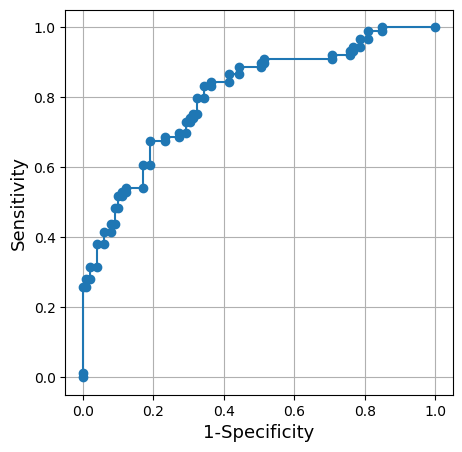

AUC: 0.8039950062421972
Sensitivity 83.15%, Specificity 65.66%, Threshold 46.08%
Sensitivity 93.26%, Specificity 23.49%, Threshold 0.15
Sensitivity 27.90%, Specificity 98.99%, Threshold 0.80


In [15]:
import os
import pickle
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing import image

def image_classifier(img, crop_width, crop_height, model, class_indices, verbose=True):

    # Sizes of tensorflow input
    img_width, img_height = 512, 512
    feature_dim = (img_width, img_height, 3)

    # Image operation
    width, height = img.size
    n_width = width // crop_width
    n_height = height // crop_height

    result = []

    # Plot prediction
    copy_img = img.copy()
    for i in range(n_width):
        sub_summary = []
        for j in range(n_height):
            img_crop = copy_img.crop((i*crop_width, j*crop_height, (i+1)*crop_width, (j+1)*crop_height))
            img_crop = img_crop.resize((img_width, img_height))

            # Tensorflow settings
            x = image.img_to_array(img_crop)
            x = np.expand_dims(x, axis=0)
            x = x / 255.0

            # Prediction
            pred = model.predict(x)[0]
            sub_summary.append(pred)
            if verbose:
                print("################# Evaluating region ({:02d}, {:02d})... #################".format(i, j))
                for cls, prob in zip(classes, pred):
                    print("{0:50}{1:8.4f}%".format(cls, prob * 100.0))
        result.append(sub_summary)
    
    return result

def calc_overall_probability(class_indices, result, max_method=False, max_key="", verbose=True):
    # Classes and indices
    classes = list(class_indices.keys())
    background_idx = class_indices["Background"]

    # Summary
    summary = dict.fromkeys(class_indices)
    for key in summary.keys():
        summary[key] = []

    for ss in result:
        for s in ss:
            class_idx = np.argmax(s)

            # Summary
            if class_idx != background_idx:
                for cls, prob in zip(classes, s):
                    summary[cls].append(prob*100)

    overall_prob = dict.fromkeys(class_indices)

    if max_method:
        idx = np.argmax(summary[max_key])
        for key in overall_prob.keys():
            overall_prob[key] = summary[key][idx]
    else:
        for key in overall_prob.keys():
            overall_prob[key] = sum(summary[key])/len(summary[key])

    if verbose:
        print("########################### Summary #############################")
        for key in overall_prob.keys():
            print("{0:50}{1:8.4f}%".format(key, overall_prob[key]))

    return overall_prob

import glob
from PIL import Image

path = ".//ROC"
species = ["Staphylococcus aureus", "Coagulase-negative Staphylococcus"]
#species = ["Coagulase-negative Staphylococcus"]

probs = dict.fromkeys(species)
for key in probs.keys():
    probs[key] = []

# Load model and class indices
ver = "InceptionResNetV2"
base_dir = "./"
ver_dir = base_dir + ver

model_path = os.path.join(ver_dir, "weights-InceptionResNetV2.hdf5")
model = tf.keras.models.load_model(model_path)
print("Loaded {}".format(model_path))

class_indices_path = os.path.join(ver_dir, 'class_indices.pickle')
with open(class_indices_path,'rb') as f:
    class_indices = pickle.load(f)

# Evaluate overall probability of each snapshot
for sp in species:
    files = glob.glob(path + "/" + sp + "/*.JPG")
    for filename in files:
        img = Image.open(filename)
        # Image classification
        crop_width, crop_height = 512, 512
        result = image_classifier(img, crop_width, crop_height, model, class_indices, verbose=False)

        # Calculate overall probability
#        overall_prob = image_analysis.calc_overall_probability(class_indices, result, max_method=True, max_key="Staphylococcus aureus")
        overall_prob = calc_overall_probability(class_indices, result)
        probs[sp].append(overall_prob)
        print("Evaluated {}".format(filename))

# ROC analysis
from sklearn import metrics
import matplotlib.pyplot as plt
target = "Staphylococcus aureus"
y_true = []
y_pred = []
for sp in probs.keys():
    for prob in probs[sp]:
        y_true.append(1 if sp == target else 0)
        y_pred.append(prob[target]/100.0)

print(y_true)
print(y_pred)

# Plot distribution
import pandas as pd
import numpy as np
df = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
x0 = df[df['y_true']==0]['y_pred']
x1 = df[df['y_true']==1]['y_pred']

plt.style.use('default')

fig = plt.figure(figsize=(6,5)) #
ax = fig.add_subplot(1, 1, 1)
ret = ax.hist([x0, x1], bins=10, stacked=False, label=["CNS", "S. aureus"])
hist_max = int(np.max(ret[0]))

plt.xticks(np.arange(0, 1.1, 0.1), fontsize = 13)
plt.yticks(np.arange(0, hist_max+1, 5), fontsize = 13)

plt.xlabel('Score', fontsize = 13)
plt.ylabel('Number of cases', fontsize = 13)
plt.legend()

#plt.ylim(0, 10)
plt.show()

# ROC analysis
fpr, tpr, thres = metrics.roc_curve(y_true, y_pred, drop_intermediate=True)
print(1-fpr)
print(tpr)
print(thres)

# Score vs sensitivity/specificity
plt.figure(figsize=(5,5))
spc = 1 - fpr
plt.plot(thres, tpr, marker='o', label="Sensitivity")
plt.plot(thres, spc, marker="+", label="Specificity")
plt.legend(loc="best")
plt.xlabel("Threshold", fontsize=13)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.1)
plt.xticks(np.arange(0, 1.1, 0.1), fontsize = 13)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize = 13)
plt.ylabel("Sensitivity/Specificity", fontsize=13)
plt.show()

# ROC curve
plt.figure(figsize = (5, 5))
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1-Specificity', fontsize = 13)
plt.ylabel('Sensitivity', fontsize = 13)
plt.grid()
plt.show()

auc = metrics.auc(fpr, tpr)
print('AUC:', auc)

# Youden index
sgn = 1 - fpr
tpr_sgn_1 = tpr + sgn - 1
idx = np.argmax(tpr_sgn_1)
Th = thres[idx]
Se = tpr[idx]
Sp = sgn[idx]
print("Sensitivity {:.2f}%, Specificity {:.2f}%, Threshold {:.2f}%".format(Se*100, Sp*100, Th*100))

# Sensitivity and specificity at 0.15 and 0.8 thresholds
from scipy import interpolate
se_linear = interpolate.interp1d(thres, tpr, kind='linear')
sp_linear = interpolate.interp1d(thres, sgn, kind='linear')

Se_15 = se_linear(0.15)
Sp_15 = sp_linear(0.15)
print("Sensitivity {:.2f}%, Specificity {:.2f}%, Threshold 15%".format(Se_15*100, Sp_15*100))

Se_80 = se_linear(0.8)
Sp_80 = sp_linear(0.8)
print("Sensitivity {:.2f}%, Specificity {:.2f}%, Threshold 80%".format(Se_80*100, Sp_80*100))


dict_keys(['Staphylococcus aureus', 'Background', 'Coagulase-negative Staphylococcus'])


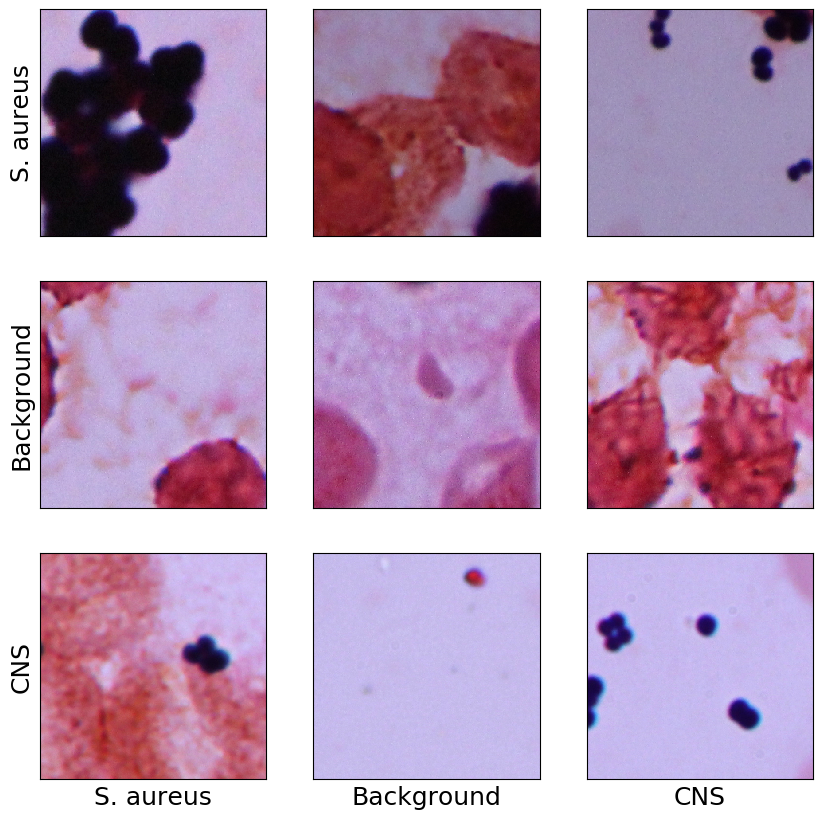

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:222: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:222: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:222: MatplotlibDeprecationWarning: Adding an axes us

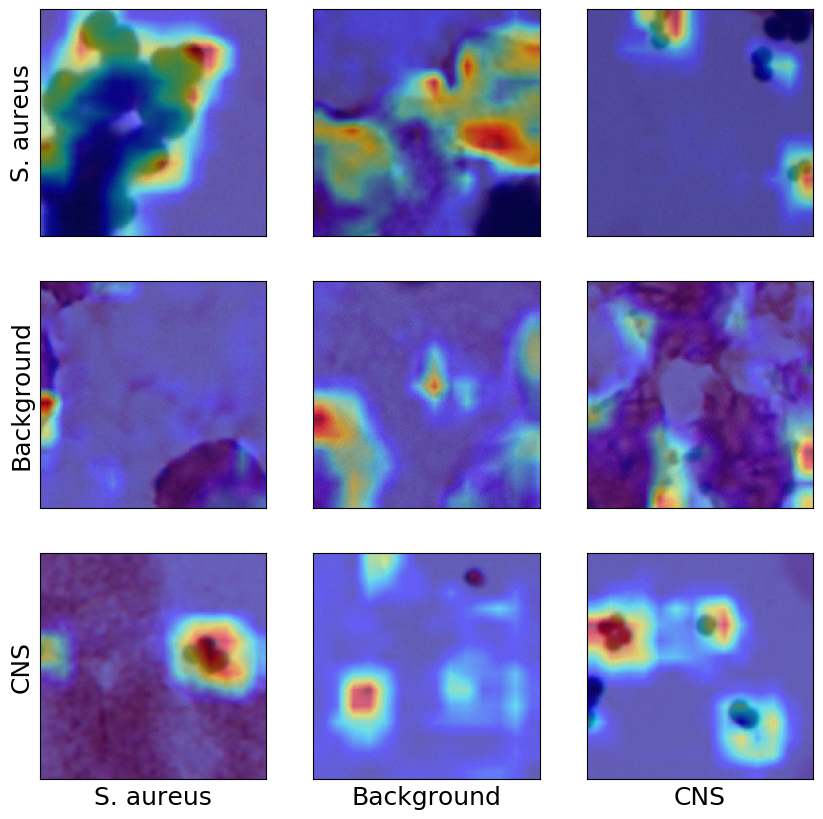

In [19]:
import tensorflow as tf
import cv2
import glob
import numpy as np
from tensorflow.keras import models

from skimage.transform import resize

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

def grad_cam(model, x, layer, width, height):
    """
    Args: 
        model(object): モデルオブジェクト
        x(ndarray): 画像
        layer(string): 畳み込み層の名前
        width, height: 画像のサイズ
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """
    img = np.expand_dims(x, axis=0)
    img = img / 255.0

    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer)
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        iterate.layers[-1].activation = tf.keras.activations.linear
        model_out, last_conv_layer = iterate(img)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap[0], (width, height), cv2.INTER_LINEAR)

    return heatmap


def guided_grad_cam(input_model, x, layer_name, img_width, img_height):
    """
    Args: 
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
        img_width, img_height: 画像のサイズ
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    IMAGE_SIZE = (img_width, img_height)
    X = np.expand_dims(x, axis=0)
    preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])
    grad_model.layers[-1].activation = tf.keras.activations.linear

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # 勾配を計算
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    # 重みを平均化して、レイヤーの出力に乗じる
    weights = np.mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    return heatmap

def grad_cam_plus_plus(model, x, layer, width, height):
    """
    Args: 
        model(object): モデルオブジェクト
        x(ndarray): 画像
        layer(string): 畳み込み層の名前
        width, height: 画像のサイズ
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """
    img = np.expand_dims(x, axis=0)
    img = img / 255.0

    last_conv_layer = model.get_layer(layer)
    grad_model = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    grad_model.layers[-1].activation = tf.keras.activations.linear

    with tf.GradientTape() as tape:
        predictions, conv_outs = grad_model(img) 
        class_idx = np.argmax(predictions[0])
        y_c = predictions[:, class_idx]

    batch_grads = tape.gradient(y_c, conv_outs) 
    grads = batch_grads[0]
    first = tf.exp(y_c) * grads
    second = tf.exp(y_c) * tf.pow(grads, 2)
    third = tf.exp(y_c) * tf.pow(grads, 3)

    global_sum = tf.reduce_sum(tf.reshape(conv_outs[0], shape=(-1, first.shape[2])), axis=0)
    alpha_num = second
    alpha_denom = second * 2.0 + third * tf.reshape(global_sum, shape=(1,1,first.shape[2]))
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones(shape=alpha_denom.shape))
    alphas = alpha_num / alpha_denom
    weights = tf.maximum(first, 0.0)
    alpha_normalization_constant = tf.reduce_sum(tf.reduce_sum(alphas, axis=0), axis=0)
    alphas /= tf.reshape(alpha_normalization_constant, shape=(1,1,first.shape[2]))
    alphas_thresholding = np.where(weights, alphas, 0.0)

    alpha_normalization_constant = tf.reduce_sum(tf.reduce_sum(alphas_thresholding, axis=0),axis=0)
    alpha_normalization_constant_processed = tf.where(alpha_normalization_constant != 0.0, alpha_normalization_constant,
                                                        tf.ones(alpha_normalization_constant.shape))

    alphas /= tf.reshape(alpha_normalization_constant_processed, shape=(1,1,first.shape[2]))
    deep_linearization_weights = tf.reduce_sum(tf.reshape((weights*alphas), shape=(-1,first.shape[2])), axis=0)
    grad_CAM_map = tf.reduce_sum(deep_linearization_weights * conv_outs[0], axis=2)
    cam = np.maximum(grad_CAM_map, 0)
    cam = cam / np.max(cam)  
    cam = resize(cam, (width,height))
    return cam

import os
import sys
import tensorflow as tf
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
from keras import backend as K
from tensorflow.keras import models
from keras.preprocessing.image import array_to_img, img_to_array, load_img

ver = "InceptionResNetV2"

base_dir = "./"
ver_dir = base_dir + ver
data_dir = base_dir + "images"

input_filenames = glob.glob(ver_dir + "/most_likely/*.png")

# Parameters
class_indices_path = os.path.join(ver_dir, 'class_indices.pickle')
with open(class_indices_path,'rb') as f:
    class_indices = pickle.load(f)
#classes = list(class_indices.keys())
classes = ["S. aureus", "CNS", "Background"]
num_classes = len(classes)
img_width, img_height = 512, 512
feature_dim = (img_width, img_height, 3)

# Load model
model = tf.keras.models.load_model(os.path.join(ver_dir, "weights-InceptionResNetV2.hdf5"))
#model.summary()

fig = plt.figure(figsize=(10.0,10.0))
cols = 3
rows = 3

for i in range(rows):
  for j in range(cols):
    input_filename = ver_dir + "/most_likely/{}to{}.png".format(i, j)
    img = img_to_array(load_img(input_filename, target_size=(img_height, img_width)))

    # Plot
    ax = fig.add_subplot(rows, cols, j + i*3 + 1)
    ax.imshow(array_to_img(img))
    if i == 2:
      ax.set_xlabel("{}".format(classes[j]), fontsize=18)
    if j == 0:
      ax.set_ylabel("{}".format(classes[i]), fontsize=18)
    
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

plt.show()

fig = plt.figure(figsize=(10.0,10.0))
for i in range(rows):
  for j in range(cols):
    input_filename = ver_dir + "/most_likely/{}to{}.png".format(i, j)
    img = img_to_array(load_img(input_filename, target_size=(img_height, img_width)))

    # Set labels
    ax = fig.add_subplot(rows, cols, j + i*rows + 1)
    ax.imshow(array_to_img(img))
    if i == 2:
      ax.set_xlabel("{}".format(classes[j]), fontsize=18)
    if j == 0:
      ax.set_ylabel("{}".format(classes[i]), fontsize=18)
    
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

    # Generate heatmap with Guided GradCAM
    target_layer = "conv_7b_ac"
    ax = fig.add_subplot(rows, cols, j + i*rows + 1)
    heatmap = grad_cam(model, img, target_layer, img_width, img_height)
#    heatmap = guided_grad_cam(model, img, target_layer, img_width, img_height)
#    heatmap = grad_cam_plus_plus(model, img, target_layer, img_width, img_height)
    ax.imshow(array_to_img(img))
    ax.imshow(heatmap, alpha=0.5, cmap='jet')

plt.show()
